<a href="https://colab.research.google.com/github/AtabonfackBernes/AtabonfackBernes/blob/main/Water_level_bottle_image_classification_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Water level Bottle image Classification

# Your proposed models should reach atleast at  80% of accuracy

### Imported libraries

This starter code version for tensor flow however you are allowed to implement similar approach using any other libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms



### Set all parameters

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS= [16,32, 64, 128, 256]
EPOCHS= 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


## Import data

In [6]:
# !unzip WaterBottleImageDataset.zip

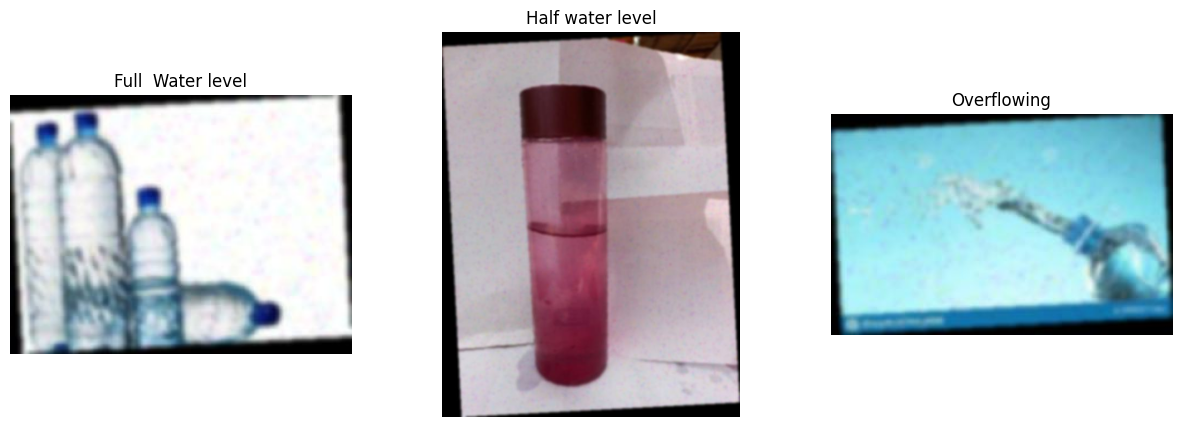

In [7]:
from PIL import Image

# Specify the paths to the images
image_paths = [
    'WaterBottleImageDataset/Full  Water level/images2_129_11zon.jpeg',
    'WaterBottleImageDataset/Half water level/unnamed (8)_41_11zon.jpeg',
    'WaterBottleImageDataset/Overflowing/download (15)_6_11zon.jpeg'
]

# Create a figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Open and display the images
for i, path in enumerate(image_paths):
    image = Image.open(path)
    axs[i].imshow(image)
    axs[i].set_title(path.split('/')[1])  # Use the folder name as the title
    axs[i].axis('off')  # Hide the axis

plt.show()

## Loading and Augmenting the data

In [8]:

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert PIL image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Load the data from the subfolders in 'WaterBottleImageDataset'
dataset = datasets.ImageFolder(root='WaterBottleImageDataset', transform=transform)

# Get the class names
class_names = dataset.classes
print("clas labels: ",class_names)


# Splitting the data

from torch.utils.data import random_split

# Define the proportions
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create test and validation data loaders
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)



import imgaug.augmenters as iaa

# Define a transform for the training data
train_transform = iaa.Sequential([
    # iaa.Resize(224),  # Resize images to 224x224
    iaa.Fliplr(0.5),  # Randomly flip the images horizontally
    iaa.GaussianBlur(sigma=(0, 0.15)),  # Apply Gaussian blur with a sigma between 0 and 0.15
    iaa.Multiply((0.7, 1.3)),  # Change brightness (80-120% of original value)
    iaa.LinearContrast((0.65, 1.5)),  # Change contrast
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Add Gaussian noise

])

from torchvision.transforms import ToTensor
from torch.utils.data import ConcatDataset

# Create a custom dataset for the initial training data
class InitialTrainDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        if self.transform:
            image = self.transform(image=image.numpy())
        image = torch.from_numpy(image).float()
        return image, label

# Create the initial training dataset with the imgaug transform
initial_train_dataset = InitialTrainDataset(train_dataset, transform=train_transform)

# Create the final training dataset by concatenating the initial and augmented datasets
final_train_dataset = ConcatDataset([initial_train_dataset, train_dataset])

# Create the final training data loader
train_dataloader = torch.utils.data.DataLoader(final_train_dataset, batch_size=32, shuffle=True)






clas labels:  ['Full  Water level', 'Half water level', 'Overflowing']


## Displaying data set structure

In [10]:
# Get the number of batches in the DataLoader
train_b = len(train_dataloader)
test_b = len(test_dataloader)
val_b = len(val_dataloader)

print(f"Number of train batches: {train_b}")
print(f"Number of test batches: {test_b}")
print(f"Number of val batches: {val_b}")

# Get the first batch of data
first_batch_images, first_batch_labels = next(iter(train_dataloader))

# Get the shape of the images and labels in the first batch
print(f"Images shape in the first train batch: {first_batch_images.shape}")
print(f"Labels shape in the first train batch: {first_batch_labels.shape}")

Number of train batches: 22
Number of test batches: 3
Number of val batches: 3
Images shape in the first train batch: torch.Size([32, 3, 128, 128])
Labels shape in the first train batch: torch.Size([32])


## Build The Model

In [11]:
import torch.nn as nn
from torchsummary import summary

class ConvNet(nn.Module):
    def __init__(self, num_classes=3):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.1))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.1))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.1))
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.1))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.1))
        self.fc1 = nn.Linear(4*4*256, 500)
        self.fc2 = nn.Linear(500,128)
        self.batch_n = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.1)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.fc2(out)
        out = self.batch_n(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

# Create an instance of the network
cnn_model = ConvNet(num_classes=3)

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = cnn_model.to(device)

# Print the summary
from torchsummary import summary
summary(cnn_model, (3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]           1,216
       BatchNorm2d-2         [-1, 16, 128, 128]              32
         LeakyReLU-3         [-1, 16, 128, 128]               0
         MaxPool2d-4           [-1, 16, 64, 64]               0
           Dropout-5           [-1, 16, 64, 64]               0
            Conv2d-6           [-1, 32, 64, 64]          12,832
       BatchNorm2d-7           [-1, 32, 64, 64]              64
         LeakyReLU-8           [-1, 32, 64, 64]               0
         MaxPool2d-9           [-1, 32, 32, 32]               0
          Dropout-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          18,496
      BatchNorm2d-12           [-1, 64, 32, 32]             128
        LeakyReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

### Defining the Loss function, Optimizer and Learning rate scheduler

In [12]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

### Training The model

In [13]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct_predictions = 0.0
    total_predictions = 0.0

    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = (correct_predictions / total_predictions) * 100

    return avg_loss, accuracy

## compute model evaluation

In [14]:
def evaluate(dataloader, model, criterion):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0.0
    total_predictions = 0.0

    # We don't need to track gradients for evaluation, so wrap in
    # no_grad to save memory
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate the running loss
            running_loss += loss.item()

            # Calculate the number of correct predictions
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    # Calculate the average loss and accuracy
    avg_loss = running_loss / len(dataloader)
    accuracy = (correct_predictions / total_predictions )*100

    return avg_loss, accuracy

In [15]:
import copy
def fit(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs):
    best_accuracy = 0.0
    best_weights = copy.deepcopy(model.state_dict())

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, criterion, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate(val_dataloader, model, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), '/content/best_weight/best_model_weights.pth')

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% | '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    model.load_state_dict(best_weights)

    return train_losses, train_accuracies, val_losses, val_accuracies

## Fitting the Model

In [ ]:
num_epochs = 100
train_losses, train_accuracies, val_losses, val_accuracies = fit(
    cnn_model,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    num_epochs
)


Epoch 1/100 | Train Loss: 1.1652, Train Accuracy: 39.26% | Val Loss: 1.0636, Val Accuracy: 56.94%
Epoch 2/100 | Train Loss: 1.0450, Train Accuracy: 55.15% | Val Loss: 1.0110, Val Accuracy: 59.72%
Epoch 3/100 | Train Loss: 1.0112, Train Accuracy: 54.41% | Val Loss: 0.9622, Val Accuracy: 59.72%
Epoch 4/100 | Train Loss: 0.9514, Train Accuracy: 57.94% | Val Loss: 0.7405, Val Accuracy: 80.56%
Epoch 5/100 | Train Loss: 0.9332, Train Accuracy: 60.74% | Val Loss: 0.8303, Val Accuracy: 72.22%
Epoch 6/100 | Train Loss: 0.8944, Train Accuracy: 60.29% | Val Loss: 0.8550, Val Accuracy: 70.83%
Epoch 7/100 | Train Loss: 0.9073, Train Accuracy: 61.76% | Val Loss: 0.6894, Val Accuracy: 75.00%
Epoch 8/100 | Train Loss: 0.8940, Train Accuracy: 62.21% | Val Loss: 0.5940, Val Accuracy: 81.94%
Epoch 9/100 | Train Loss: 0.8295, Train Accuracy: 64.85% | Val Loss: 0.6933, Val Accuracy: 83.33%
Epoch 10/100 | Train Loss: 0.8110, Train Accuracy: 65.44% | Val Loss: 0.6493, Val Accuracy: 70.83%
Epoch 11/100 | Trai

## Testing the data

In [ ]:
cnn_model = ConvNet(num_classes=3)
cnn_model.load_state_dict(torch.load('/content/best_weight/best_model_weights1.pth'))
cnn_model.eval()

test_loss, test_accuracy = evaluate(test_dataloader, cnn_model, criterion)
print(f"Test Loss for Custom model: {test_loss} ")
print(f"Test Accuracy for Custom: {test_accuracy}")

Test Loss for Custom model: 0.19320037215948105 
Test Accuracy for Custom: 95.94594594594594


## Plotting the Train and Validation Loss and Accuracy

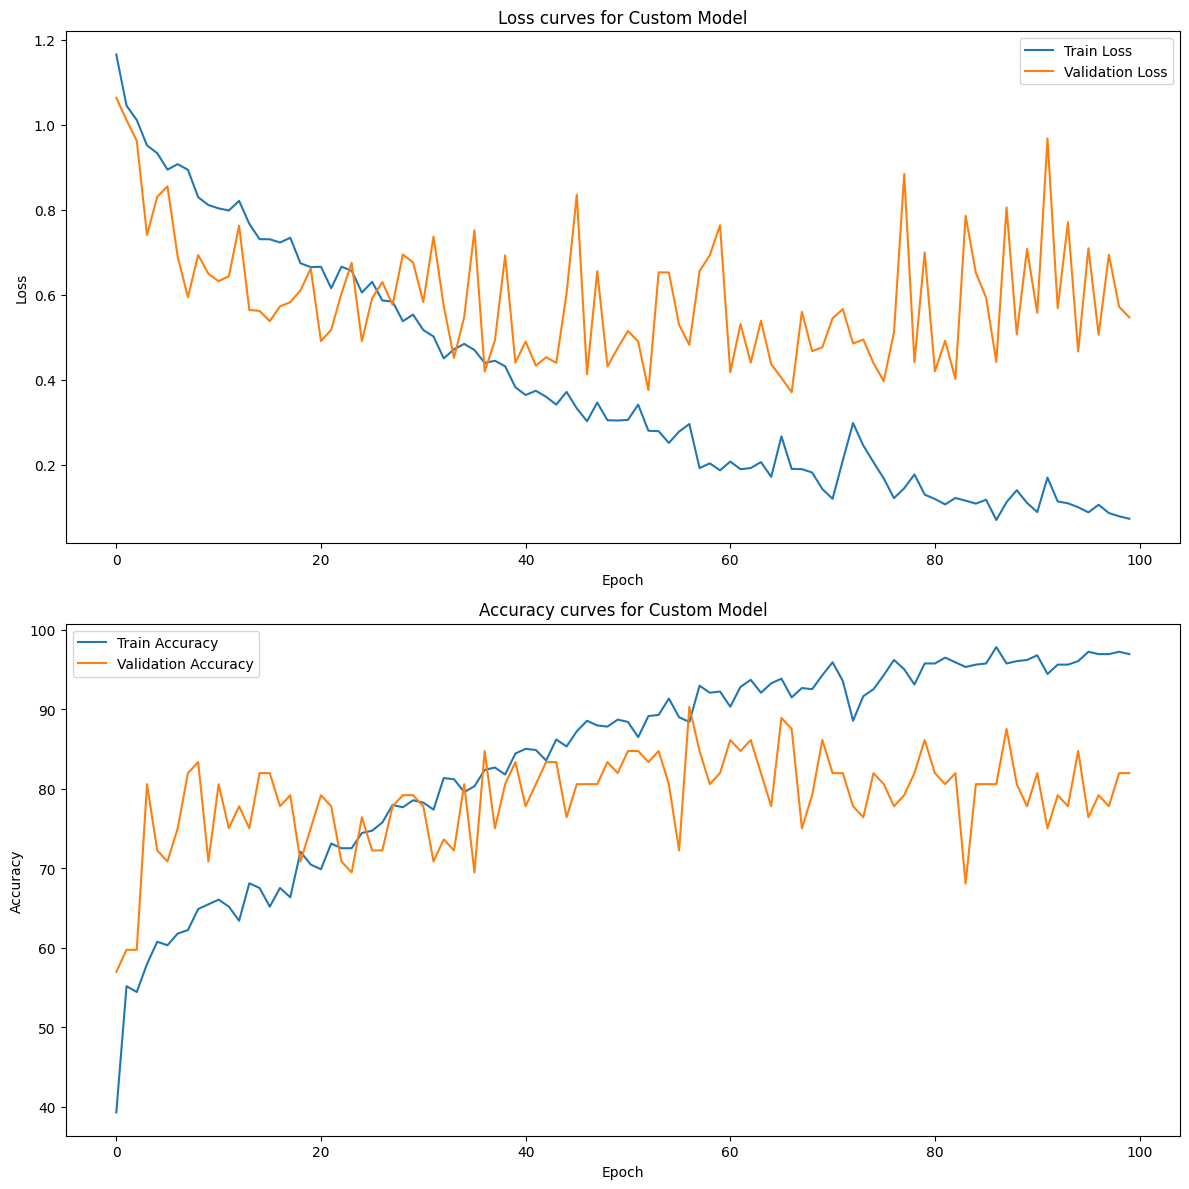

In [ ]:
import matplotlib.pyplot as plt

# Create a figure for the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot the loss curves
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss curves for Custom Model')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the accuracy curves
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Accuracy curves for Custom Model')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### Write a function for inference

In [ ]:

class_names = dataset.classes



In [ ]:
def predict_image(image_path, model, class_names):
    # Load the image
    image = Image.open(image_path)

    # Define the preprocessing steps
    transform = transforms.Compose([
      transforms.Resize((128, 128)),  # Resize images to 224x224
      transforms.ToTensor(),  # Convert PIL image to Tensor
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
    ])
    # Preprocess the image
    input = transform(image)

    # Add an extra batch dimension since pytorch treats all images as batches
    input = input.unsqueeze(0)

    with torch.no_grad():
        # Move the input to the device
        input = input.to(device)

        # Forward pass
        output = model(input)

        # Get the predicted class
        _, predicted = torch.max(output.data, 1)

        # Convert class index to class name
        predicted_class = class_names[predicted.item()]

    return predicted_class

In [ ]:
dataset.classes

['Full  Water level', 'Half water level', 'Overflowing']

In [ ]:
print(predict_image("/content/WaterBottleImageDataset/Full  Water level/1000_F_181641215_ZAQ5NSDRONequztAW4ipiNfPlyuEa3s0_19_11zon.jpeg",cnn_model,dataset.classes))
print(predict_image("/content/WaterBottleImageDataset/Half water level/1-liter-drinking-water-pet-bottle-995-w300_2_11zon.jpeg",cnn_model,dataset.classes))
print(predict_image("/content/WaterBottleImageDataset/Overflowing/download (1)_1_11zon.jpeg",cnn_model,dataset.classes))

Full  Water level
Half water level
Overflowing


In [26]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import torch

def display_image_and_predictions(image_path, model, class_names, actual_label):
    # Load the image
    image = Image.open(image_path)

    # Define the preprocessing steps
    transform = transforms.Compose([
      transforms.Resize((128, 128)),  # Resize images to 128x128
      transforms.ToTensor(),  # Convert PIL image to Tensor
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
    ])

    # Preprocess the image
    input = transform(image)

    # Add an extra batch dimension since pytorch treats all images as batches
    input = input.unsqueeze(0)

    with torch.no_grad():
        # Move the input to the device
        input = input.to(device)

        # Forward pass
        output = model(input)

        # Get the predicted class
        _, predicted = torch.max(output.data, 1)

        # Convert class index to class name
        predicted_class = class_names[predicted.item()]

    # Display the image, actual label, and predicted label
    plt.imshow(image)
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_class}")
    plt.axis('off')
    plt.tight_layout
    plt.show()

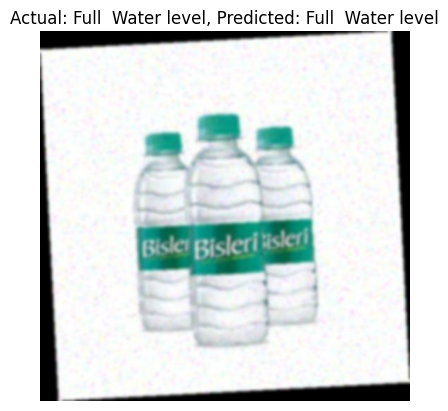

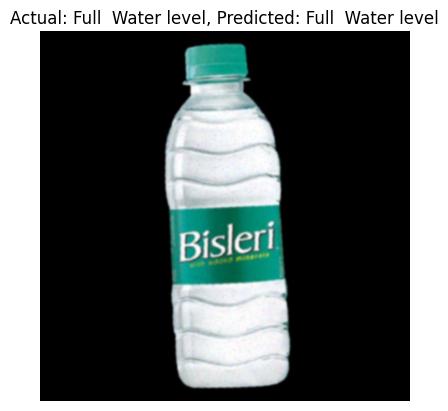

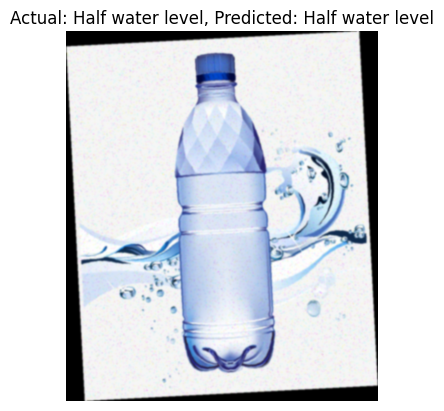

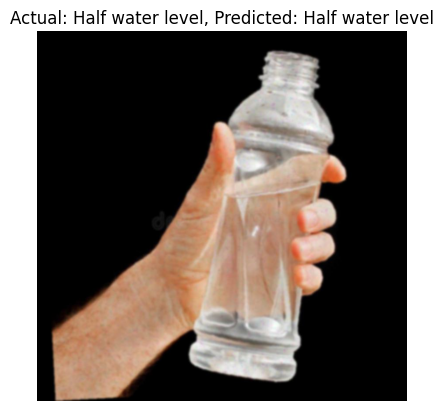

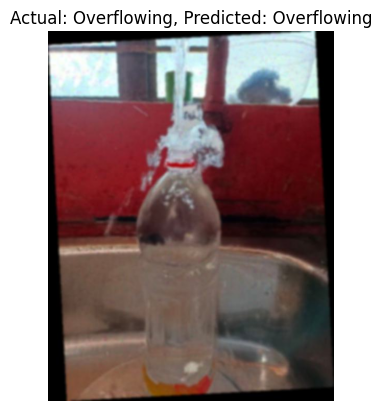

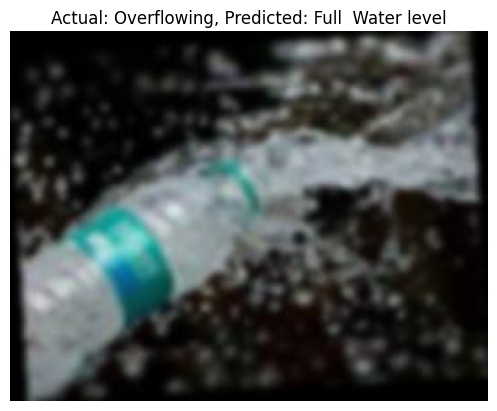

In [ ]:
image_paths = ["/content/WaterBottleImageDataset/Full  Water level/250-ml-bisleri-water-bottle-500x500_13_11zon.jpeg","/content/WaterBottleImageDataset/Full  Water level/412087_1-bisleri-mineral-water_29_11zon.jpeg","/content/WaterBottleImageDataset/Half water level/56-562880_cartoon-waterdrop-mineral-water-element-water-bottle-splash.png","/content/WaterBottleImageDataset/Half water level/astic-water-bottle-half-filled-clear-clean-drinking-water-isolated-204332879_16_11zon.jpeg","/content/WaterBottleImageDataset/Overflowing/unnamed (13)_6_11zon.jpeg","/content/WaterBottleImageDataset/Overflowing/images115_201_11zon.jpeg"]
labels = ['Full  Water level','Full  Water level', 'Half water level','Half water level', 'Overflowing','Overflowing']
for i in range(len(image_paths)):
  display_image_and_predictions(image_paths[i],cnn_model,dataset.classes,labels[i])



## Iplementing ResNet32

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=3):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = conv3x3(3,16)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[2:])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet32():
    return ResNet(BasicBlock, [5, 5, 5])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


resnet32 = ResNet32()
resnet32 = resnet32.to(device)
summary(resnet32, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             432
       BatchNorm2d-2         [-1, 16, 128, 128]              32
            Conv2d-3         [-1, 16, 128, 128]           2,304
       BatchNorm2d-4         [-1, 16, 128, 128]              32
            Conv2d-5         [-1, 16, 128, 128]           2,304
       BatchNorm2d-6         [-1, 16, 128, 128]              32
        BasicBlock-7         [-1, 16, 128, 128]               0
            Conv2d-8         [-1, 16, 128, 128]           2,304
       BatchNorm2d-9         [-1, 16, 128, 128]              32
           Conv2d-10         [-1, 16, 128, 128]           2,304
      BatchNorm2d-11         [-1, 16, 128, 128]              32
       BasicBlock-12         [-1, 16, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]           2,304
      BatchNorm2d-14         [-1, 16, 1

## Training and Validating the ResNet

In [33]:
num_epochs = 100
train_losses, train_accuracies, val_losses, val_accuracies = fit(
    resnet32,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    num_epochs
)

Epoch 1/100 | Train Loss: 1.8167, Train Accuracy: 18.82% | Val Loss: 1.2375, Val Accuracy: 27.78%
Epoch 2/100 | Train Loss: 1.8324, Train Accuracy: 18.97% | Val Loss: 1.3560, Val Accuracy: 27.78%
Epoch 3/100 | Train Loss: 1.8199, Train Accuracy: 18.82% | Val Loss: 1.3026, Val Accuracy: 27.78%
Epoch 4/100 | Train Loss: 1.8393, Train Accuracy: 18.68% | Val Loss: 1.3499, Val Accuracy: 27.78%
Epoch 5/100 | Train Loss: 1.7880, Train Accuracy: 20.29% | Val Loss: 1.3824, Val Accuracy: 27.78%
Epoch 6/100 | Train Loss: 1.8117, Train Accuracy: 20.15% | Val Loss: 1.3447, Val Accuracy: 27.78%
Epoch 7/100 | Train Loss: 1.8074, Train Accuracy: 19.12% | Val Loss: 1.3360, Val Accuracy: 26.39%
Epoch 8/100 | Train Loss: 1.7981, Train Accuracy: 17.79% | Val Loss: 1.3874, Val Accuracy: 27.78%
Epoch 9/100 | Train Loss: 1.8072, Train Accuracy: 19.26% | Val Loss: 1.3680, Val Accuracy: 26.39%
Epoch 10/100 | Train Loss: 1.8156, Train Accuracy: 18.68% | Val Loss: 1.3457, Val Accuracy: 27.78%
Epoch 11/100 | Trai

## Prediction Results for the ResNet

In [34]:
resnet32 = ResNet32()
resnet32.load_state_dict(torch.load('/content/best_weight/best_model_weights.pth'))
resnet32.eval()
resnet32.to(device)

test_loss, test_accuracy = evaluate(test_dataloader, resnet32, criterion)
print(f"Test Loss for Custom model: {test_loss}")
print(f"Test Accuracy for Custom: {test_accuracy}")

Test Loss for Custom model: 1.2383045355478923
Test Accuracy for Custom: 31.08108108108108


## Graph of Loss and Accuracy of the ResNet Model

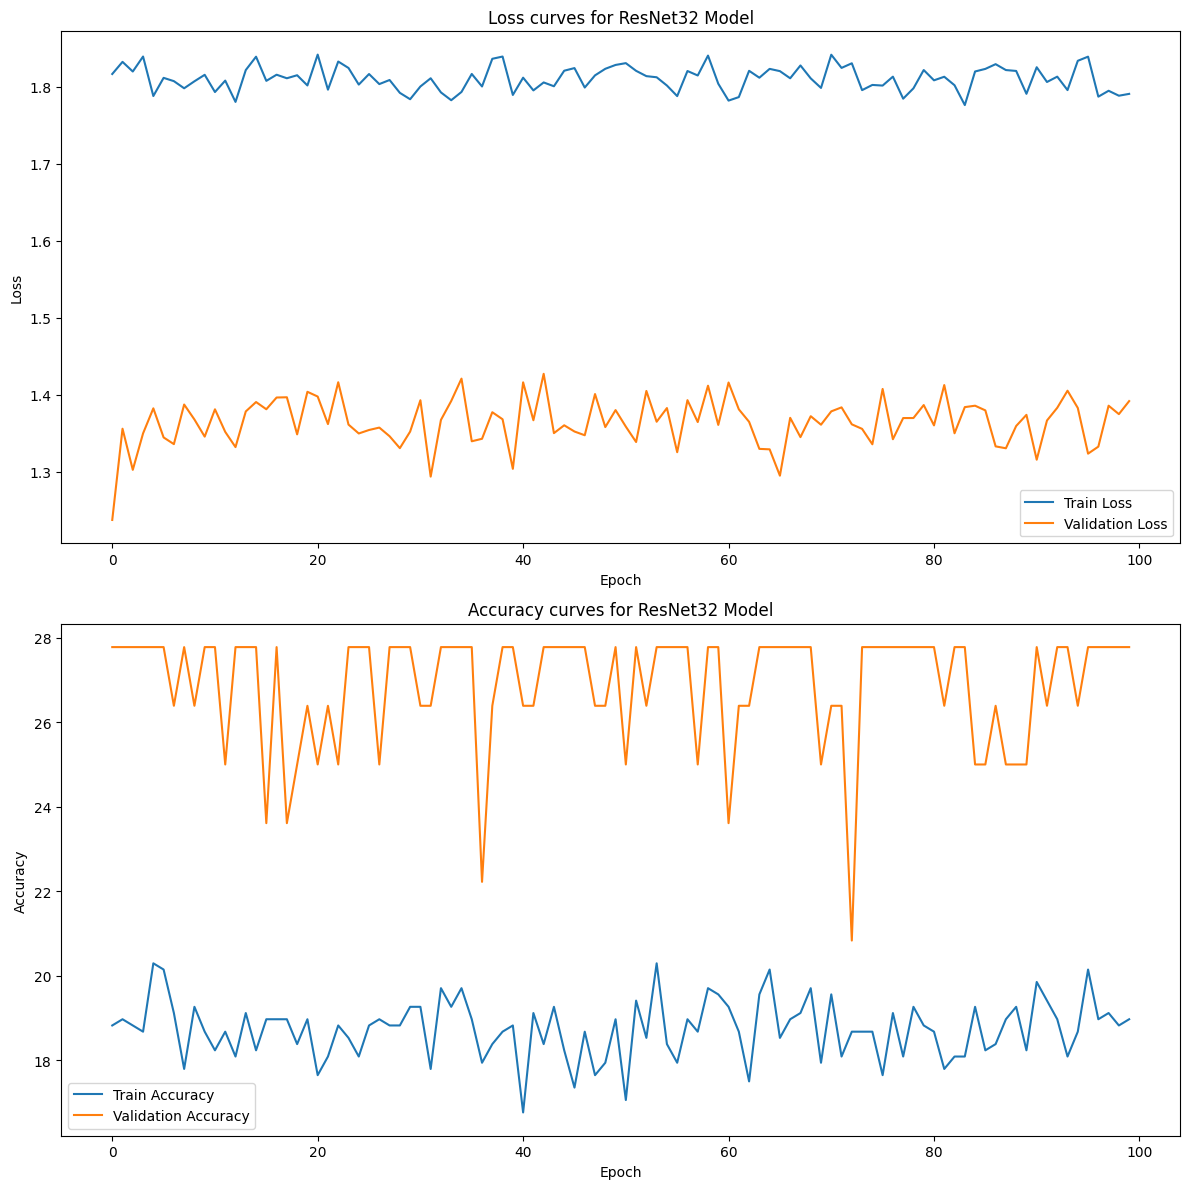

In [35]:
import matplotlib.pyplot as plt

# Create a figure for the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot the loss curves
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss curves for ResNet32 Model')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the accuracy curves
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Accuracy curves for ResNet32 Model')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

## Inference on the ResNet Model

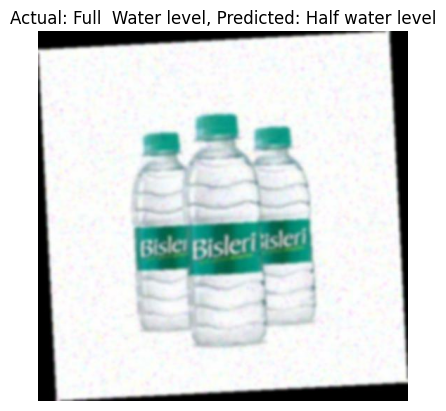

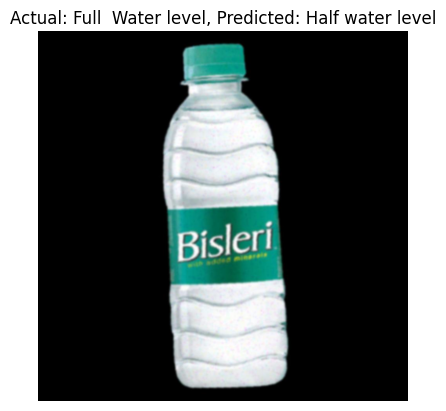

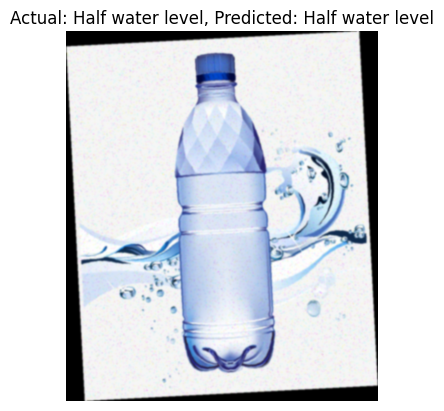

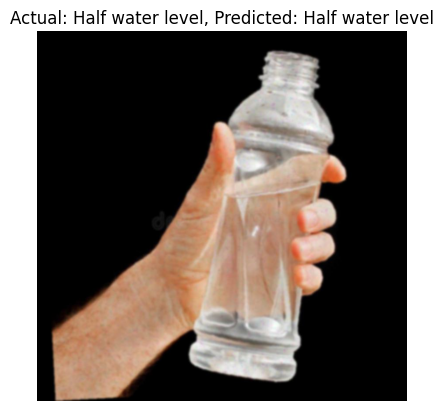

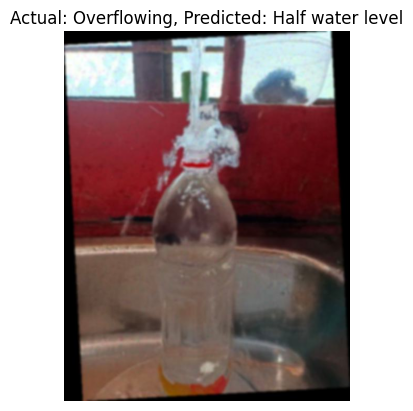

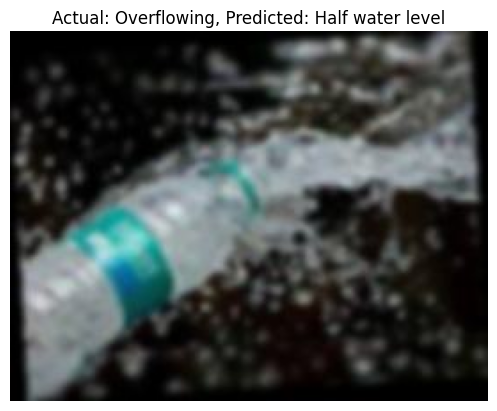

In [36]:
image_paths = ["/content/WaterBottleImageDataset/Full  Water level/250-ml-bisleri-water-bottle-500x500_13_11zon.jpeg","/content/WaterBottleImageDataset/Full  Water level/412087_1-bisleri-mineral-water_29_11zon.jpeg","/content/WaterBottleImageDataset/Half water level/56-562880_cartoon-waterdrop-mineral-water-element-water-bottle-splash.png","/content/WaterBottleImageDataset/Half water level/astic-water-bottle-half-filled-clear-clean-drinking-water-isolated-204332879_16_11zon.jpeg","/content/WaterBottleImageDataset/Overflowing/unnamed (13)_6_11zon.jpeg","/content/WaterBottleImageDataset/Overflowing/images115_201_11zon.jpeg"]
labels = ['Full  Water level','Full  Water level', 'Half water level','Half water level', 'Overflowing','Overflowing']
for i in range(len(image_paths)):
  display_image_and_predictions(image_paths[i],resnet32,dataset.classes,labels[i])

